In [162]:
import pandas as pd
import numpy as np
from datetime import datetime
import re
import os # Import os for file path operations
# import googlemaps # No longer used as we're using a Kaggle dataset, not the API
# import time # No longer used
import shutil
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, skew, kurtosis
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from prophet import Prophet
#from scipy.spatial import KDTree # Import KDTree for spatial indexing

In [163]:
# === SETUP ===
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

# Load dataset from Excel
file_path = "../data/raw/global-superstore.xlsx"
df_orders = pd.read_excel(file_path, sheet_name="Orders")
df_returns = pd.read_excel(file_path, sheet_name="Returns")
df_people = pd.read_excel(file_path, sheet_name="People") # Load the 'People' sheet

print("Orders:")
print(df_orders.info())
print("\nReturns:")
print(df_returns.info())
print("\nPeople:")
print(df_people.info())

Orders:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Row ID          51290 non-null  int64         
 1   Order ID        51290 non-null  object        
 2   Order Date      51290 non-null  datetime64[ns]
 3   Ship Date       51290 non-null  datetime64[ns]
 4   Ship Mode       51290 non-null  object        
 5   Customer ID     51290 non-null  object        
 6   Customer Name   51290 non-null  object        
 7   Segment         51290 non-null  object        
 8   City            51290 non-null  object        
 9   State           51290 non-null  object        
 10  Country         51290 non-null  object        
 11  Postal Code     9994 non-null   float64       
 12  Market          51290 non-null  object        
 13  Region          51290 non-null  object        
 14  Product ID      51290 non-null  object        

In [164]:
print("\nSample orders data:")
print(df_orders.head())
print("\nSample returns data:")
print(df_returns.head())
print("\nSample people data:")
print(df_people.head())


Sample orders data:
   Row ID         Order ID Order Date  Ship Date     Ship Mode Customer ID  \
0   32298   CA-2012-124891 2012-07-31 2012-07-31      Same Day    RH-19495   
1   26341    IN-2013-77878 2013-02-05 2013-02-07  Second Class    JR-16210   
2   25330    IN-2013-71249 2013-10-17 2013-10-18   First Class    CR-12730   
3   13524  ES-2013-1579342 2013-01-28 2013-01-30   First Class    KM-16375   
4   47221     SG-2013-4320 2013-11-05 2013-11-06      Same Day     RH-9495   

      Customer Name      Segment           City            State  \
0       Rick Hansen     Consumer  New York City         New York   
1     Justin Ritter    Corporate     Wollongong  New South Wales   
2      Craig Reiter     Consumer       Brisbane       Queensland   
3  Katherine Murray  Home Office         Berlin           Berlin   
4       Rick Hansen     Consumer          Dakar            Dakar   

         Country  Postal Code  Market   Region        Product ID    Category  \
0  United States     

In [165]:
print("Missing values in orders:\n", df_orders.isnull().sum())
print("\nMissing values in returns:\n", df_returns.isnull().sum())
print("\nMissing values in people:\n", df_people.isnull().sum())
print("Duplicate rows in orders:", df_orders.duplicated().sum())
print("Duplicate rows in returns:", df_returns.duplicated().sum())
print("Duplicate rows in people:", df_people.duplicated().sum())

Missing values in orders:
 Row ID                0
Order ID              0
Order Date            0
Ship Date             0
Ship Mode             0
Customer ID           0
Customer Name         0
Segment               0
City                  0
State                 0
Country               0
Postal Code       41296
Market                0
Region                0
Product ID            0
Category              0
Sub-Category          0
Product Name          0
Sales                 0
Quantity              0
Discount              0
Profit                0
Shipping Cost         0
Order Priority        0
dtype: int64

Missing values in returns:
 Returned    0
Order ID    0
Market      0
dtype: int64

Missing values in people:
 Person    0
Region    0
dtype: int64
Duplicate rows in orders: 0
Duplicate rows in returns: 0
Duplicate rows in people: 0


In [166]:
df_orders = df_orders.drop(columns=['Postal Code'])

In [167]:
# === MERGE RETURN FLAG ===
df_orders = df_orders.merge(
    df_returns[["Order ID", "Returned"]],
    on="Order ID",
    how="left"
)
df_orders["Returned"] = df_orders["Returned"].fillna("No").astype("category")
print("\nDataFrame df_orders after merging Return Flag:")
print(df_orders.head())


DataFrame df_orders after merging Return Flag:
   Row ID         Order ID Order Date  Ship Date     Ship Mode Customer ID  \
0   32298   CA-2012-124891 2012-07-31 2012-07-31      Same Day    RH-19495   
1   26341    IN-2013-77878 2013-02-05 2013-02-07  Second Class    JR-16210   
2   25330    IN-2013-71249 2013-10-17 2013-10-18   First Class    CR-12730   
3   13524  ES-2013-1579342 2013-01-28 2013-01-30   First Class    KM-16375   
4   47221     SG-2013-4320 2013-11-05 2013-11-06      Same Day     RH-9495   

      Customer Name      Segment           City            State  \
0       Rick Hansen     Consumer  New York City         New York   
1     Justin Ritter    Corporate     Wollongong  New South Wales   
2      Craig Reiter     Consumer       Brisbane       Queensland   
3  Katherine Murray  Home Office         Berlin           Berlin   
4       Rick Hansen     Consumer          Dakar            Dakar   

         Country  Market   Region        Product ID    Category Sub-Catego

In [168]:
print("\nCurrent columns in df_orders:", df_orders.columns.tolist())


Current columns in df_orders: ['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'City', 'State', 'Country', 'Market', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit', 'Shipping Cost', 'Order Priority', 'Returned']


In [169]:
print("Missing values in orders:\n", df_orders.isnull().sum())

Missing values in orders:
 Row ID            0
Order ID          0
Order Date        0
Ship Date         0
Ship Mode         0
Customer ID       0
Customer Name     0
Segment           0
City              0
State             0
Country           0
Market            0
Region            0
Product ID        0
Category          0
Sub-Category      0
Product Name      0
Sales             0
Quantity          0
Discount          0
Profit            0
Shipping Cost     0
Order Priority    0
Returned          0
dtype: int64


In [170]:
# --- FEATURE ENGINEERING ---
df_orders["Shipping Duration"] = (df_orders["Ship Date"] - df_orders["Order Date"]).dt.days
df_orders["Order Year"] = df_orders["Order Date"].dt.year
df_orders["Order Month"] = df_orders["Order Date"].dt.month
df_orders['Discount Rate'] = df_orders['Discount'] / (1 - df_orders['Discount'])
df_orders['Sales Category'] = pd.cut(df_orders['Sales'],
                                    bins=[0, 100, 500, 1000, 100000],
                                    labels=['Low', 'Medium', 'High', 'Very High'])

print("\nDataFrame df_orders after Feature Engineering:")
print(df_orders.head())


DataFrame df_orders after Feature Engineering:
   Row ID         Order ID Order Date  Ship Date     Ship Mode Customer ID  \
0   32298   CA-2012-124891 2012-07-31 2012-07-31      Same Day    RH-19495   
1   26341    IN-2013-77878 2013-02-05 2013-02-07  Second Class    JR-16210   
2   25330    IN-2013-71249 2013-10-17 2013-10-18   First Class    CR-12730   
3   13524  ES-2013-1579342 2013-01-28 2013-01-30   First Class    KM-16375   
4   47221     SG-2013-4320 2013-11-05 2013-11-06      Same Day     RH-9495   

      Customer Name      Segment           City            State  \
0       Rick Hansen     Consumer  New York City         New York   
1     Justin Ritter    Corporate     Wollongong  New South Wales   
2      Craig Reiter     Consumer       Brisbane       Queensland   
3  Katherine Murray  Home Office         Berlin           Berlin   
4       Rick Hansen     Consumer          Dakar            Dakar   

         Country  Market   Region        Product ID    Category Sub-Catego

In [171]:
# === DATA DESCRIPTION ===
print(df_orders.describe(include="all"))

              Row ID        Order ID                     Order Date  \
count   51295.000000           51295                          51295   
unique           NaN           25035                            NaN   
top              NaN  CA-2014-100111                            NaN   
freq             NaN              14                            NaN   
mean    25644.896598             NaN  2013-05-11 22:30:30.213471232   
min         1.000000             NaN            2011-01-01 00:00:00   
25%     12821.500000             NaN            2012-06-19 00:00:00   
50%     25645.000000             NaN            2013-07-08 00:00:00   
75%     38466.500000             NaN            2014-05-22 00:00:00   
max     51290.000000             NaN            2014-12-31 00:00:00   
std     14806.333027             NaN                            NaN   

                            Ship Date       Ship Mode Customer ID  \
count                           51295           51295       51295   
unique   

In [172]:
#numerical_variables = df.select_dtypes(exclude='O')
numerical_variables = df_orders.select_dtypes(include=['number'])
categorical_variables = df_orders.select_dtypes(include='O') #(Python) objects

numerical_variables.head()

numerical_variables.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51295 entries, 0 to 51294
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Row ID             51295 non-null  int64  
 1   Sales              51295 non-null  float64
 2   Quantity           51295 non-null  int64  
 3   Discount           51295 non-null  float64
 4   Profit             51295 non-null  float64
 5   Shipping Cost      51295 non-null  float64
 6   Shipping Duration  51295 non-null  int64  
 7   Order Year         51295 non-null  int32  
 8   Order Month        51295 non-null  int32  
 9   Discount Rate      51295 non-null  float64
dtypes: float64(5), int32(2), int64(3)
memory usage: 3.5 MB


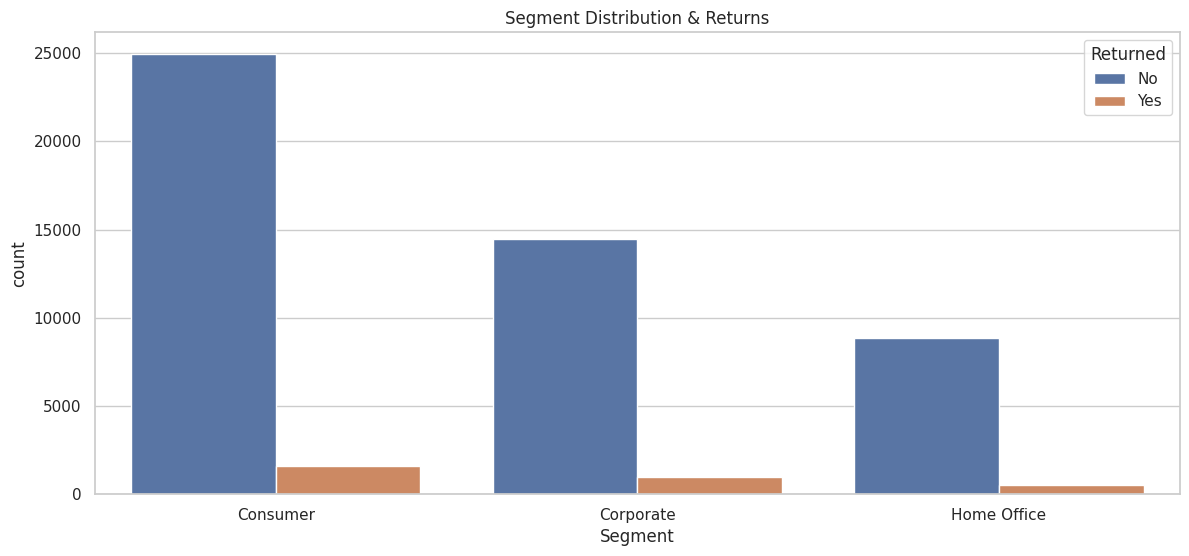

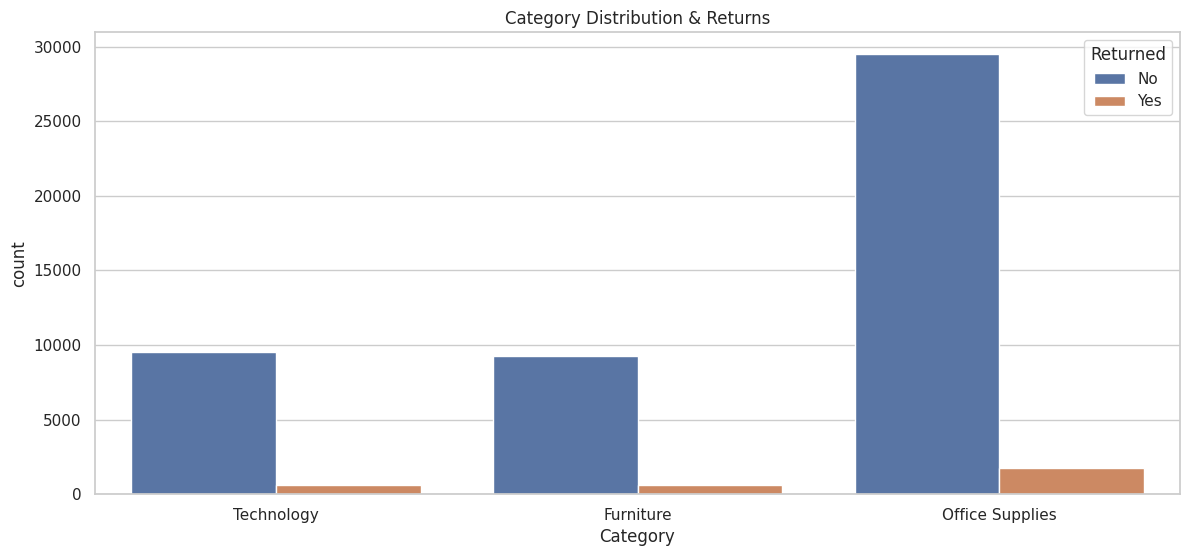

In [173]:
# === CATEGORY DISTRIBUTION ===
plt.figure(figsize=(14,6))
sns.countplot(data=df_orders, x="Segment", hue="Returned")
plt.title("Segment Distribution & Returns")
plt.show()

plt.figure(figsize=(14,6))
sns.countplot(data=df_orders, x="Category", hue="Returned")
plt.title("Category Distribution & Returns")
plt.show()


[INFO] --- Additional Step: Deeper Analysis of Categorical Variables ---

Proportion of Returns per Segment:
Segment      Returned
Consumer     No          94.027149
             Yes          5.972851
Corporate    No          93.706656
             Yes          6.293344
Home Office  No          94.650118
             Yes          5.349882
Name: proportion, dtype: float64


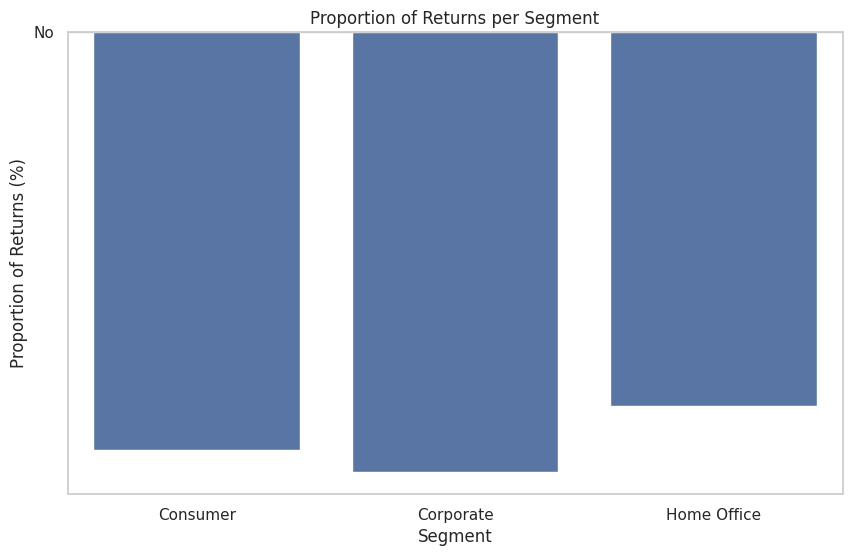

In [174]:
print("\n[INFO] --- Additional Step: Deeper Analysis of Categorical Variables ---")
# Proportion of returns in each segment
print("\nProportion of Returns per Segment:")
print(df_orders.groupby('Segment')['Returned'].value_counts(normalize=True) * 100)

# Visualize proportion of returns per segment (optional)
plt.figure(figsize=(10, 6))
sns.barplot(data=df_orders, x='Segment', y='Returned', errorbar=None)
plt.title('Proportion of Returns per Segment')
plt.ylabel('Proportion of Returns (%)')
plt.show()


Proportion of Returns per Category:
Category         Returned
Furniture        No          93.530424
                 Yes          6.469576
Office Supplies  No          94.276579
                 Yes          5.723421
Technology       No          93.828256
                 Yes          6.171744
Name: proportion, dtype: float64


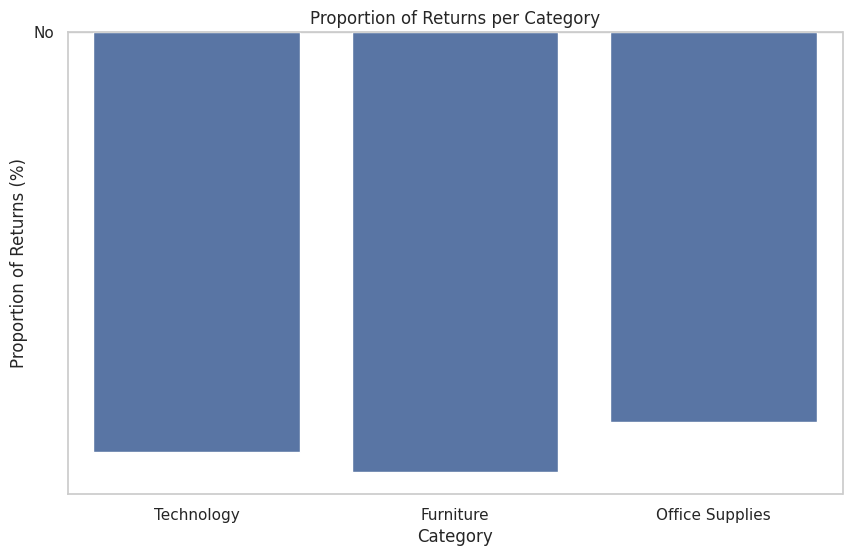


[INFO] --- Done with Categorical Variable Analysis ---


In [175]:
# Proportion of returns in each category
print("\nProportion of Returns per Category:")
print(df_orders.groupby('Category')['Returned'].value_counts(normalize=True) * 100)

# Visualize the proportion of returns per category (optional)
plt.figure(figsize=(10, 6))
sns.barplot(data=df_orders, x='Category', y='Returned', errorbar=None)
plt.title('Proportion of Returns per Category')
plt.ylabel('Proportion of Returns (%)')
plt.show()
print("\n[INFO] --- Done with Categorical Variable Analysis ---")

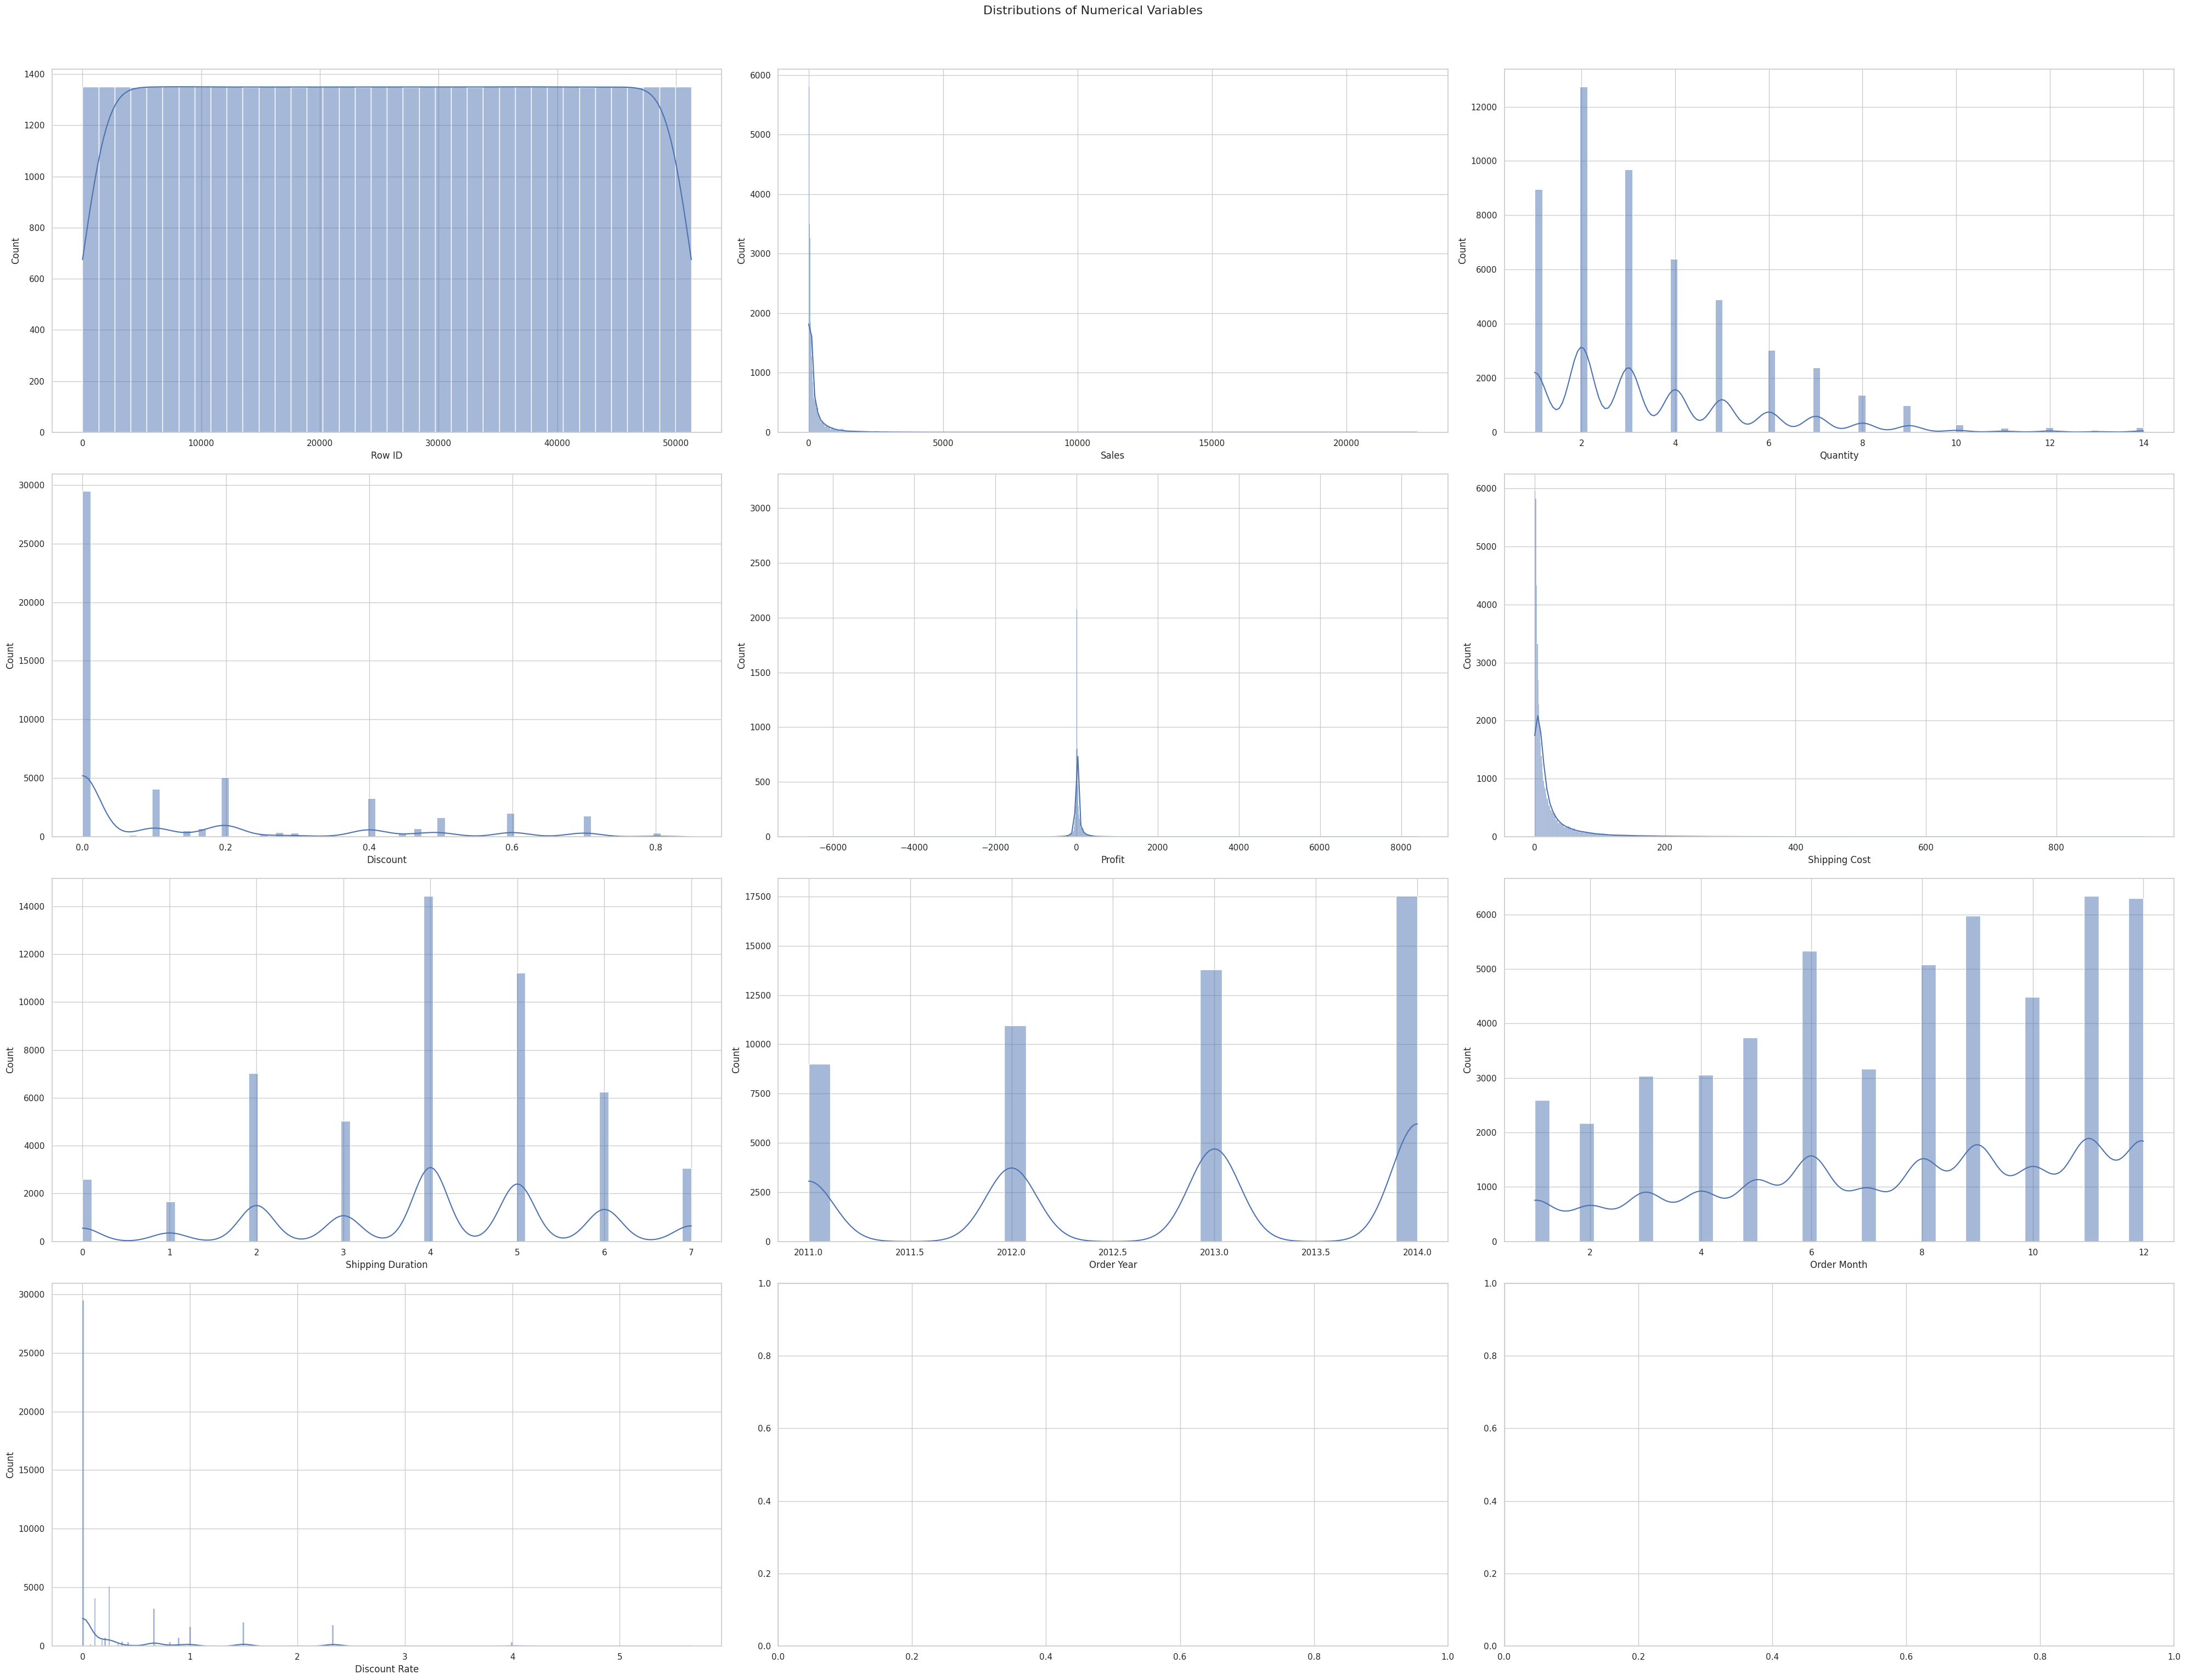

In [176]:
# === NUMERIC DISTRIBUTION ===
fig, ax = plt.subplots(4, 3, figsize=(40, 30))
for var, subplot in zip(numerical_variables, ax.flatten()): 
    sns.histplot(df_orders[var], ax=subplot, kde=True)
plt.suptitle("Distributions of Numerical Variables", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()
#plt.savefig('distribution.png')


[INFO] --- Additional Step: Numerical Variable Correlation Analysis ---


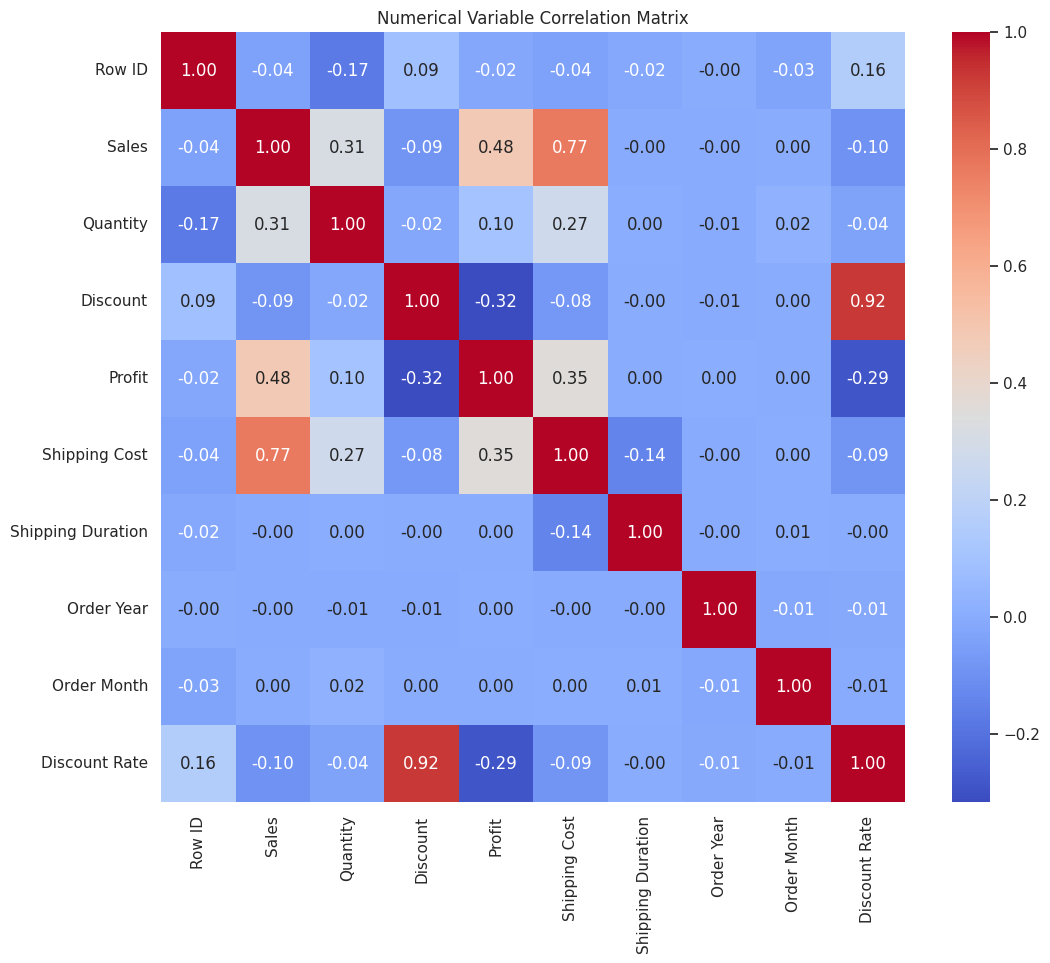


[INFO] --- Done with Numerical Correlation Analysis ---


In [177]:
print("\n[INFO] --- Additional Step: Numerical Variable Correlation Analysis ---")
# Select only numeric columns
numerical_df = df_orders.select_dtypes(include=np.number)

# Calculate the correlation matrix
correlation_matrix = numerical_df.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Numerical Variable Correlation Matrix')
plt.show()
print("\n[INFO] --- Done with Numerical Correlation Analysis ---")


[INFO] --- Additional Steps: More Detailed Distribution of Numerical Data ---

Descriptive Statistics for Column 'Row ID':
Skewness: 4.0259120178238335e-05
Kurtosis: -1.2000689118687533


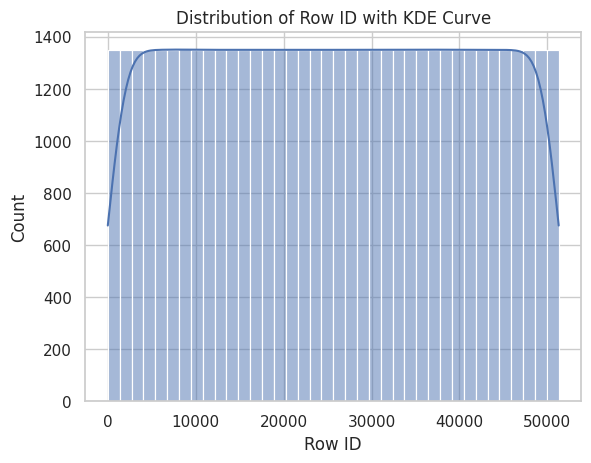


Descriptive Statistics for Column 'Sales':
Skewness: 8.138162702588636
Kurtosis: 176.72815742528115


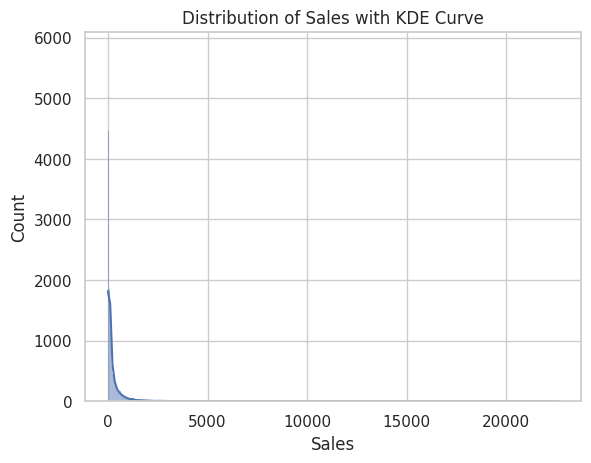


Descriptive Statistics for Column 'Quantity':
Skewness: 1.3603395448831181
Kurtosis: 2.2756459844453847


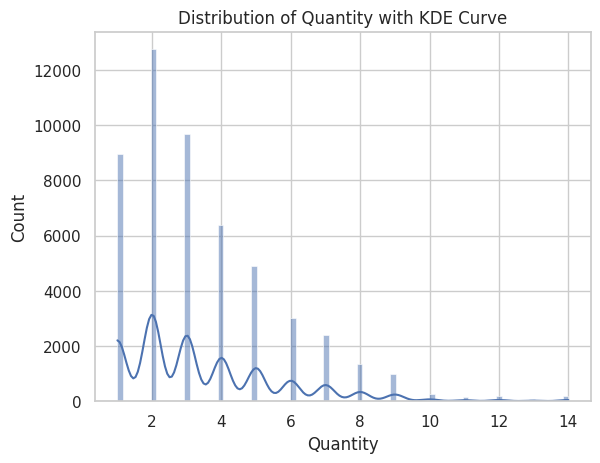


Descriptive Statistics for Column 'Discount':
Skewness: 1.3877768088322413
Kurtosis: 0.7167617581879027


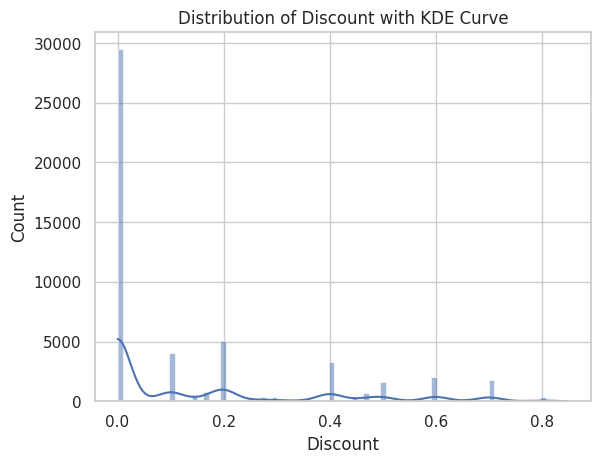


Descriptive Statistics for Column 'Profit':
Skewness: 4.157209754171642
Kurtosis: 291.40392173360675


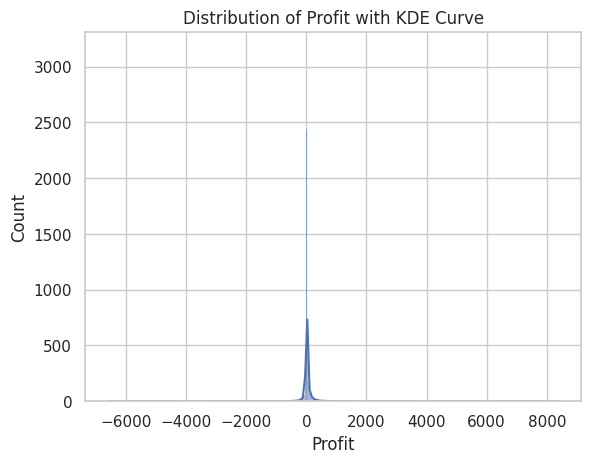


Descriptive Statistics for Column 'Shipping Cost':
Skewness: 5.863312123478918
Kurtosis: 50.01969313588512


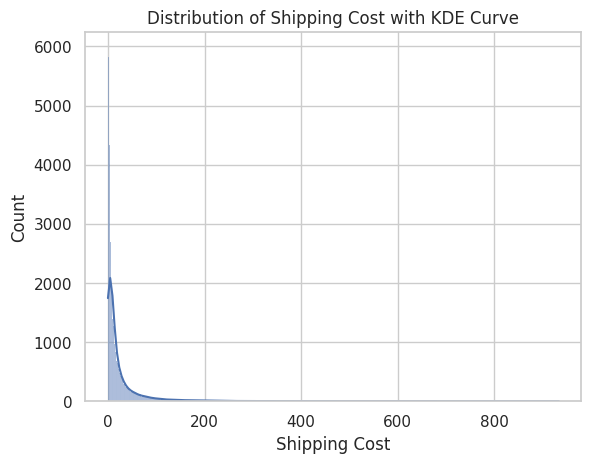


Descriptive Statistics for Column 'Shipping Duration':
Skewness: -0.4320666523121287
Kurtosis: -0.24983232396262833


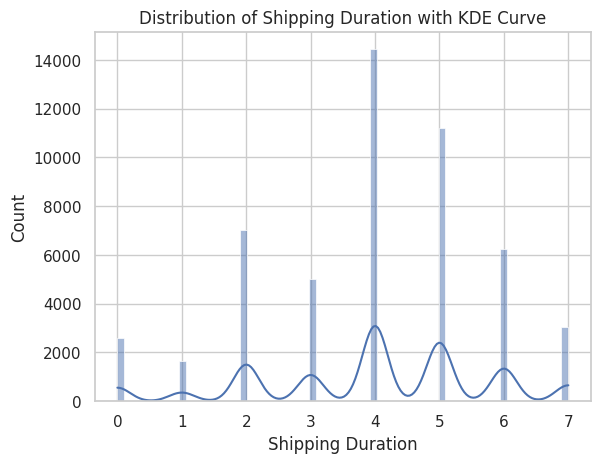


Descriptive Statistics for Column 'Order Year':
Skewness: -0.34465077679194556
Kurtosis: -1.2219881726148505


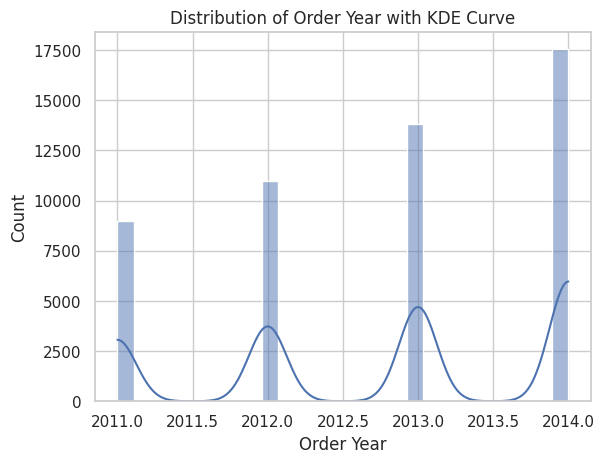


Descriptive Statistics for Column 'Order Month':
Skewness: -0.357950687881835
Kurtosis: -0.97785777584116


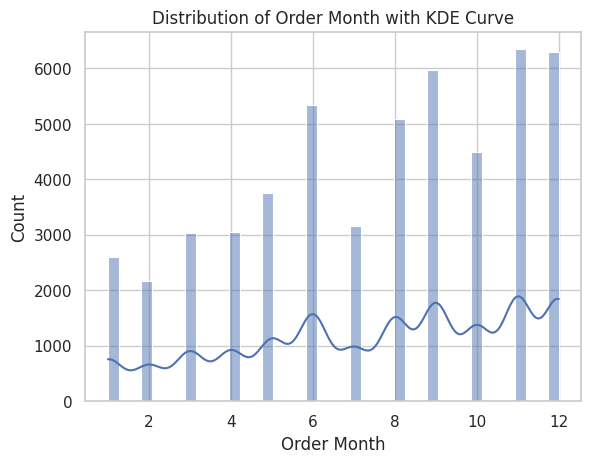


Descriptive Statistics for Column 'Discount Rate':
Skewness: 2.952428843125306
Kurtosis: 10.330286023752342


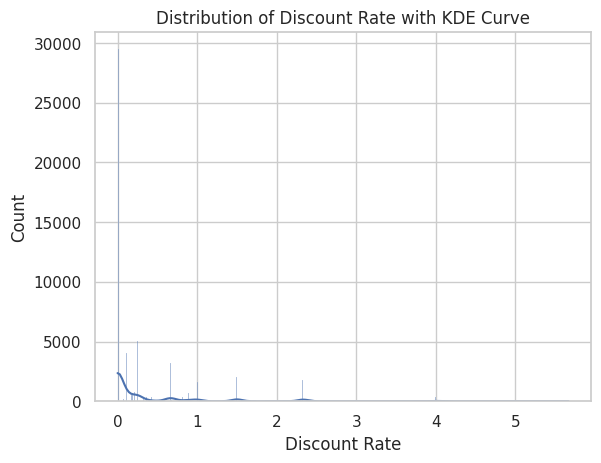


[INFO] --- Done with Numerical Distribution Analysis ---


In [178]:
print("\n[INFO] --- Additional Steps: More Detailed Distribution of Numerical Data ---")
numerical_cols = numerical_df.columns

for col in numerical_cols:
    print(f"\nDescriptive Statistics for Column '{col}':")
    print(f"Skewness: {skew(df_orders[col])}")
    print(f"Kurtosis: {kurtosis(df_orders[col])}")
    sns.histplot(df_orders[col], kde=True)
    plt.title(f'Distribution of {col} with KDE Curve')
    plt.show()
print("\n[INFO] --- Done with Numerical Distribution Analysis ---")


[INFO] --- Additional Steps: Outlier Analysis and Handling ---


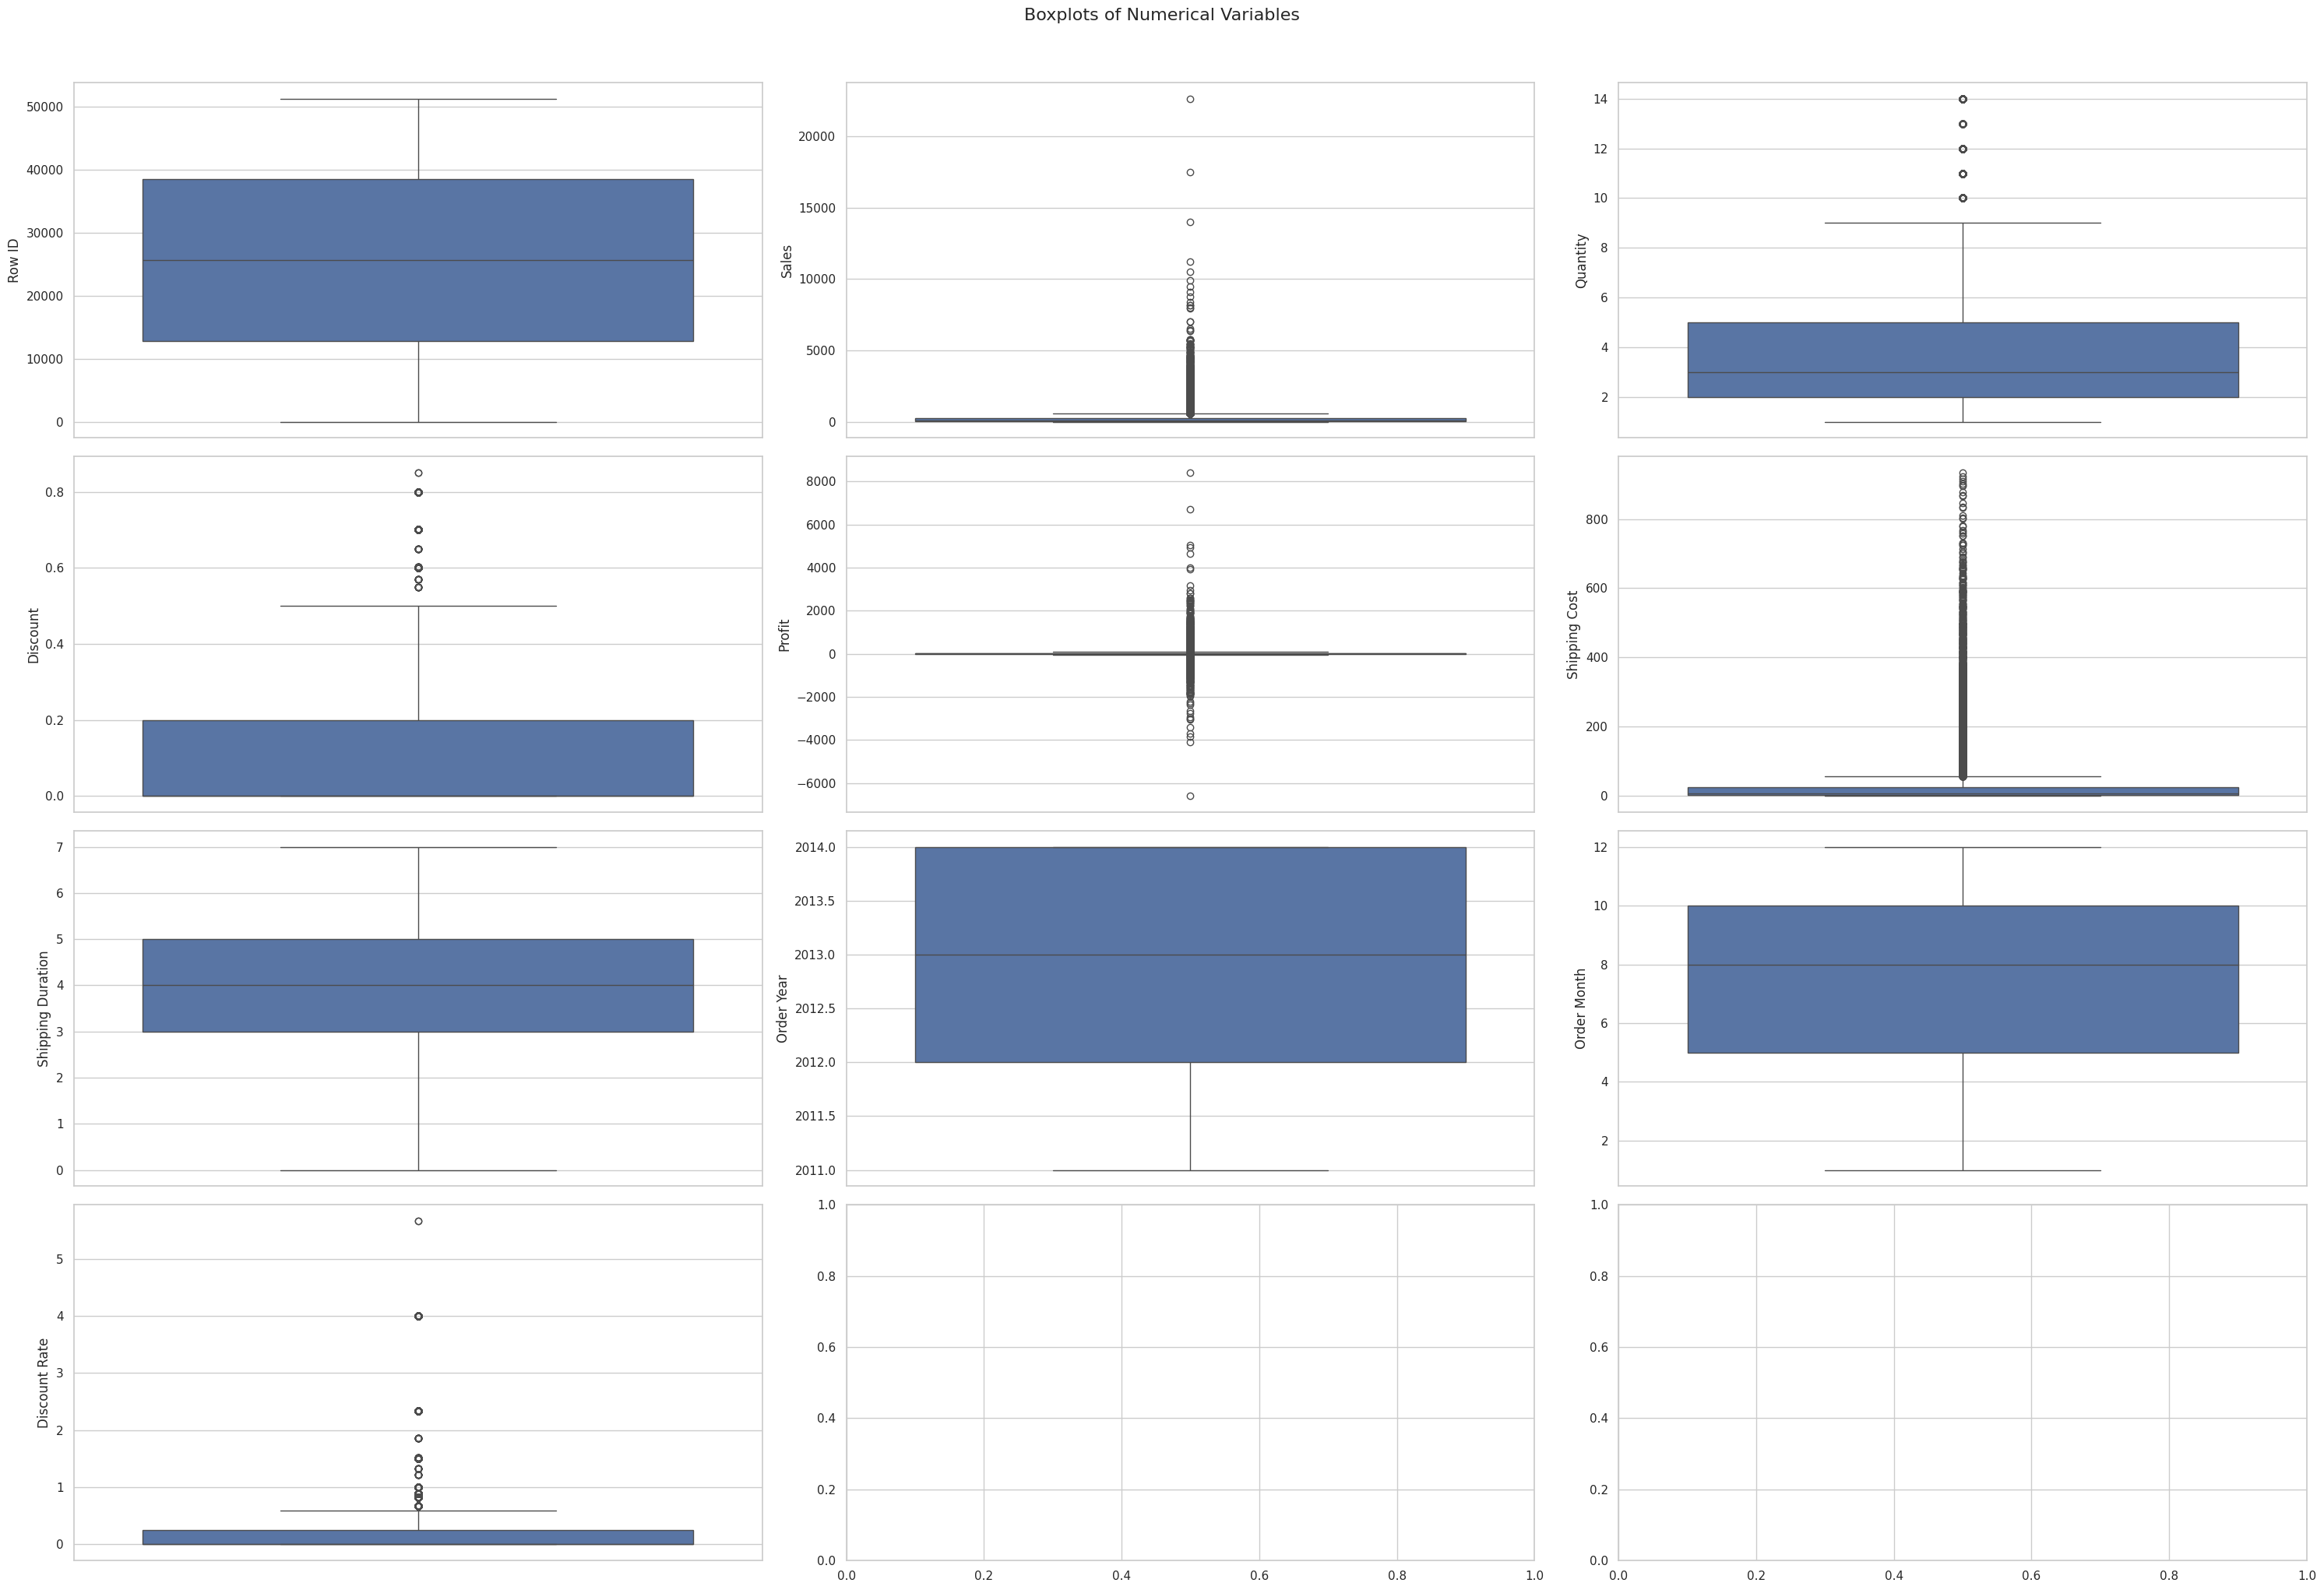

In [179]:
# === OUTLIER DETECTION: PROFIT ===
print("\n[INFO] --- Additional Steps: Outlier Analysis and Handling ---")

# Plot the boxplots for the numerical columns
fig, ax = plt.subplots(4, 3, figsize=(30,20))
for var, subplot in zip(numerical_variables, ax.flatten()): 
    sns.boxplot(df_orders[var], ax=subplot)
plt.suptitle("Boxplots of Numerical Variables", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()
#plt.savefig('outliers.png')

In [180]:
# Example of outlier analysis for column 'Profit' (you can repeat for other columns)
print("\n[OUTLIER ANALYSIS FOR COLUMN 'Profit']")
Q1_profit = df_orders['Profit'].quantile(0.25)
Q3_profit = df_orders['Profit'].quantile(0.75)
IQR_profit = Q3_profit - Q1_profit
lower_bound_profit = Q1_profit - 1.5 * IQR_profit
upper_bound_profit = Q3_profit + 1.5 * IQR_profit

print(f"First Quartile (Q1) Profit: {Q1_profit}")
print(f"Third Quartile (Q3) Profit: {Q3_profit}")
print(f"Interquartile Range (IQR) Profit: {IQR_profit}")
print(f"Lower Bound of Outlier Profit: {lower_bound_profit}")
print(f"Upper Bound Outlier Profit: {upper_bound_profit}")

# Number of outliers below the lower bound and above the upper bound
outliers_lower_profit = df_orders[df_orders['Profit'] < lower_bound_profit]
outliers_upper_profit = df_orders[df_orders['Profit'] > upper_bound_profit]
print(f"\nNumber of Outliers Below the Lower Profit Boundary: {len(outliers_lower_profit)}")
print(f"\nNumber of Outliers Above the Upper Profit Boundary: {len(outliers_upper_profit)}")

# Option to filter DataFrame without outliers in 'Profit' column (Uncomment if you want to use it)
# df_orders_no_profit_outliers = df_orders[(df_orders['Profit'] >= lower_bound_profit) & (df_orders['Profit'] <= upper_bound_profit)].copy()
# print(f"\nNumber of rows before handling Profit outliers: {len(df_orders)}")
# print(f"Number of rows after handling Profit outliers: {len(df_orders_no_profit_outliers)}")
# df_orders = df_orders_no_profit_outliers # If you decide to use the filtered DataFrame

print("\n[INFO] --- Done with Outlier Analysis and Handling ---")


[OUTLIER ANALYSIS FOR COLUMN 'Profit']
First Quartile (Q1) Profit: 0.0
Third Quartile (Q3) Profit: 36.81
Interquartile Range (IQR) Profit: 36.81
Lower Bound of Outlier Profit: -55.215
Upper Bound Outlier Profit: 92.025

Number of Outliers Below the Lower Profit Boundary: 3526

Number of Outliers Above the Upper Profit Boundary: 6230

[INFO] --- Done with Outlier Analysis and Handling ---


In [181]:
# === RETURN RATE ===
return_rate = df_orders["Returned"].value_counts(normalize=True) * 100
print("Return Rate (%):\n", return_rate)

print("\n[INFO] --- Additional Steps: Integration with 'people' Data ---")
# Merge df_orders with df_people based on 'Region'
df_orders_merged = pd.merge(df_orders, df_people, on='Region', how='left')
print("\nSample data df_orders after merging with df_people:")
print(df_orders_merged.head())

# To continue the analysis with this data, you can replace df_orders with df_orders_merged
# df_orders = df_orders_merged
print("\n[INFO] --- Done with 'people' Data Integration ---")

Return Rate (%):
 Returned
No     94.044254
Yes     5.955746
Name: proportion, dtype: float64

[INFO] --- Additional Steps: Integration with 'people' Data ---

Sample data df_orders after merging with df_people:
   Row ID         Order ID Order Date  Ship Date     Ship Mode Customer ID  \
0   32298   CA-2012-124891 2012-07-31 2012-07-31      Same Day    RH-19495   
1   26341    IN-2013-77878 2013-02-05 2013-02-07  Second Class    JR-16210   
2   25330    IN-2013-71249 2013-10-17 2013-10-18   First Class    CR-12730   
3   13524  ES-2013-1579342 2013-01-28 2013-01-30   First Class    KM-16375   
4   47221     SG-2013-4320 2013-11-05 2013-11-06      Same Day     RH-9495   

      Customer Name      Segment           City            State  \
0       Rick Hansen     Consumer  New York City         New York   
1     Justin Ritter    Corporate     Wollongong  New South Wales   
2      Craig Reiter     Consumer       Brisbane       Queensland   
3  Katherine Murray  Home Office         Berlin

In [182]:
# === SAVE RESULTS ===
df_orders.to_csv("../data/processed/processed_orders.csv", index=False)
print("[INFO] Dataset is ready and saved in ../data/processed/processed_orders.csv")

[INFO] Dataset is ready and saved in ../data/processed/processed_orders.csv


---

In [183]:
# Assumption: df_orders is your clean DataFrame after initial preprocessing

# 1. Handling Outliers for Time Series (Prophet)
df_orders_ts = df_orders.copy()

# Identify and impute outliers in 'Sales' and 'Profit' columns for time series
# (Simple example, you may use more sophisticated methods)
sales_median_ts = df_orders_ts['Sales'].median()
profit_median_ts = df_orders_ts['Profit'].median()

sales_q1_ts = df_orders_ts['Sales'].quantile(0.25)
sales_q3_ts = df_orders_ts['Sales'].quantile(0.75)
sales_iqr_ts = sales_q3_ts - sales_q1_ts
sales_lower_bound_ts = sales_q1_ts - 1.5 * sales_iqr_ts
sales_upper_bound_ts = sales_q3_ts + 1.5 * sales_iqr_ts

profit_q1_ts = df_orders_ts['Profit'].quantile(0.25)
profit_q3_ts = df_orders_ts['Profit'].quantile(0.75)
profit_iqr_ts = profit_q3_ts - profit_q1_ts
profit_lower_bound_ts = profit_q1_ts - 1.5 * profit_iqr_ts
profit_upper_bound_ts = profit_q3_ts + 1.5 * profit_iqr_ts

df_orders_ts.loc[df_orders_ts['Sales'] < sales_lower_bound_ts, 'Sales'] = sales_median_ts
df_orders_ts.loc[df_orders_ts['Sales'] > sales_upper_bound_ts, 'Sales'] = sales_median_ts
df_orders_ts.loc[df_orders_ts['Profit'] < profit_lower_bound_ts, 'Profit'] = profit_median_ts
df_orders_ts.loc[df_orders_ts['Profit'] > profit_upper_bound_ts, 'Profit'] = profit_median_ts

print("\n[INFO] Outlier handling completed for Time Series data (df_orders_ts)")


[INFO] Outlier handling completed for Time Series data (df_orders_ts)


In [184]:
# 2. Handling Outliers for Customer Analytics (Masking Approach)
df_orders_ca = df_orders.copy()

# Create a mask for positive Profit values
positive_profit_mask = df_orders_ca['Profit'] > 0

# Initialize the Profit_log column with the original Profit values
df_orders_ca['Profit_log'] = df_orders_ca['Profit'].copy()

# Apply log1p only to positive Profit values ​​using a mask
df_orders_ca.loc[positive_profit_mask, 'Profit_log'] = np.log1p(df_orders_ca.loc[positive_profit_mask, 'Profit'])

# Handle null values ​​in 'Sales' and 'Quantity' with epsilon before log
epsilon = np.finfo(float).eps
df_orders_ca['Sales_log'] = np.log1p(df_orders_ca['Sales'].replace(0, epsilon))
df_orders_ca['Quantity_log'] = np.log1p(df_orders_ca['Quantity'].replace(0, epsilon))

print("\n[INFO] Outlier handling (log transformation for positive Profit - Masking) completed for Customer Analytics data (df_orders_ca)")


[INFO] Outlier handling (log transformation for positive Profit - Masking) completed for Customer Analytics data (df_orders_ca)


In [185]:
# 3. Outlier Handling for Recommender System
df_orders_rs = df_orders.copy()

# For recommender system, outlier handling may differ depending on the features used.

# If we are using purchase amount or rating, we may want to limit the extreme values.

# (Example of limiting value, adjust limit as needed)
if 'Quantity' in df_orders_rs.columns:
    df_orders_rs['Quantity'] = df_orders_rs['Quantity'].clip(upper=50) # Limit the number of purchases per transaction

print("\n[INFO] Outlier handling completed for Recommender System data (df_orders_rs)")


[INFO] Outlier handling completed for Recommender System data (df_orders_rs)


20:28:22 - cmdstanpy - INFO - Chain [1] start processing
20:28:22 - cmdstanpy - INFO - Chain [1] done processing


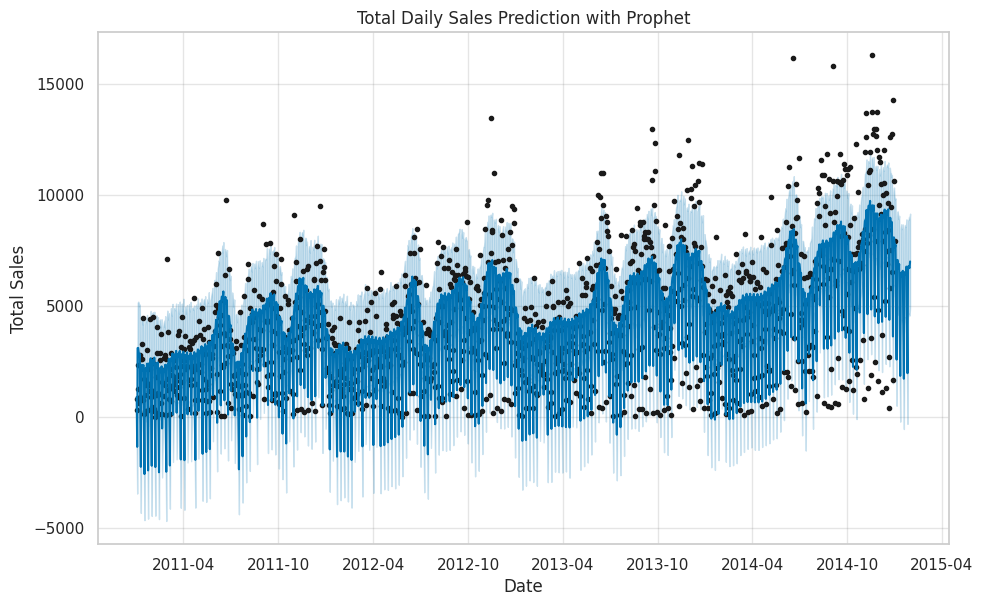

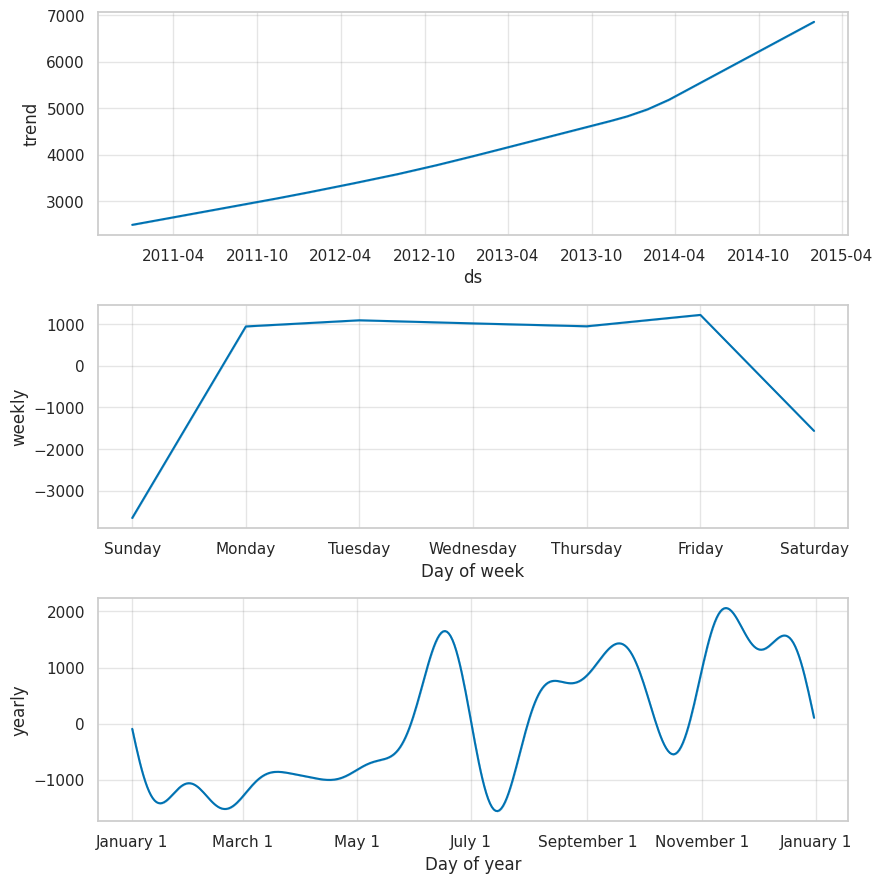


[INFO] Time Series modeling with Prophet is complete and visualization is displayed.

The first few lines of the prediction results:
          ds        trend   yhat_lower   yhat_upper  trend_lower  trend_upper  \
0 2011-01-01  2486.035139 -1313.684234  3136.195959  2486.035139  2486.035139   
1 2011-01-02  2487.826358 -3447.652467   740.697171  2487.826358  2487.826358   
2 2011-01-03  2489.617577   749.059993  5147.390459  2489.617577  2489.617577   
3 2011-01-04  2491.408795   843.085850  5196.937893  2491.408795  2491.408795   
4 2011-01-05  2493.200014   729.533813  5134.356975  2493.200014  2493.200014   

   additive_terms  additive_terms_lower  additive_terms_upper       weekly  \
0    -1581.348980          -1581.348980          -1581.348980 -1566.298101   
1    -3832.230251          -3832.230251          -3832.230251 -3660.399078   
2      619.415815            619.415815            619.415815   944.857205   
3      618.897310            618.897310            618.897310  1092

In [186]:
# Assumption: df_orders_ts already exists and is a copy of the clean data

# Make sure the 'Order Date' column is of type datetime
df_orders_ts['Order Date'] = pd.to_datetime(df_orders_ts['Order Date'])

# Aggregate total daily sales
daily_sales = df_orders_ts.groupby('Order Date')['Sales'].sum().reset_index()
daily_sales = daily_sales.rename(columns={'Order Date': 'ds', 'Sales': 'y'})

# Initialize and train the Prophet model
model = Prophet()
model.fit(daily_sales)

# Create a dataframe for future predictions (e.g., 30 days)
future = model.make_future_dataframe(periods=30)

# Make a prediction
forecast = model.predict(future)

# Visualize the prediction results
fig = model.plot(forecast)
plt.title('Total Daily Sales Prediction with Prophet')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.show()

# Visualize the prediction components (trend, seasonality)
fig2 = model.plot_components(forecast)
plt.show()

print("\n[INFO] Time Series modeling with Prophet is complete and visualization is displayed.")
print("\nThe first few lines of the prediction results:")
print(forecast.head())

20:28:24 - cmdstanpy - INFO - Chain [1] start processing
20:28:24 - cmdstanpy - INFO - Chain [1] done processing



[INFO] Prophet Model Evaluation:
Mean Squared Error (MSE): 5739904.97
Root Mean Squared Error (RMSE): 2395.81
Mean Absolute Error (MAE): 1826.88


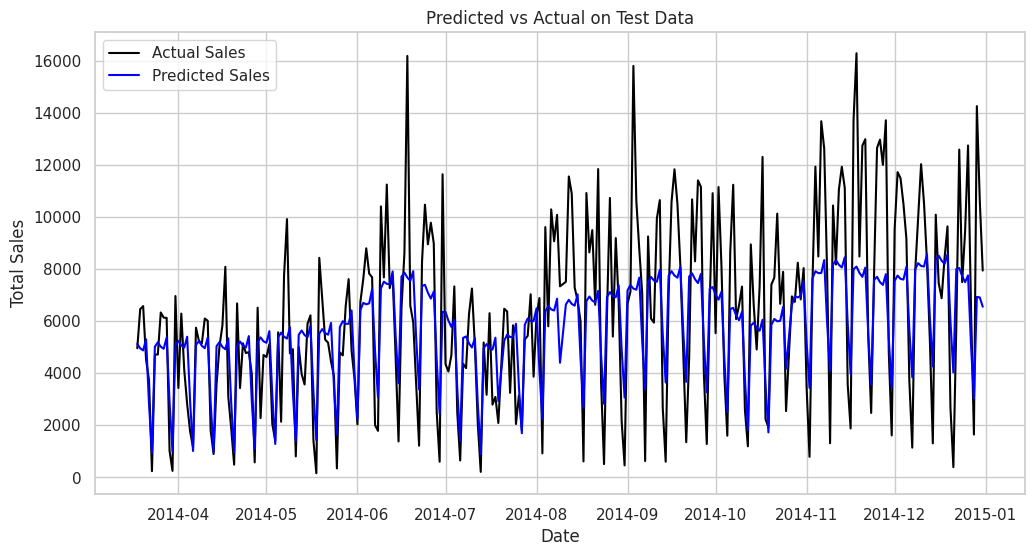

In [187]:
# Assumptions: daily_sales DataFrame already exists (previous aggregation result)

# Determine the split point for train and test (e.g., 80% of the original data for train)
train_size = int(len(daily_sales) * 0.8)
train_data = daily_sales[:train_size]
test_data = daily_sales[train_size:]

# Initialize and train the Prophet model on the train data
model_eval = Prophet()
model_eval.fit(train_data)

# Create a dataframe for predictions on the test period
future_test = pd.DataFrame(test_data['ds'])

# Make predictions on the test period
forecast_test = model_eval.predict(future_test)

# Combine the actual values ​​(y) from test_data with the predictions (yhat) from forecast_test
predictions = forecast_test[['ds', 'yhat']].set_index('ds')
actuals = test_data[['ds', 'y']].set_index('ds')
comparison = predictions.join(actuals)

# Calculate evaluation metrics
mse = mean_squared_error(comparison['y'], comparison['yhat'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(comparison['y'], comparison['yhat'])

print("\n[INFO] Prophet Model Evaluation:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

# Visualize predicted vs actual results on data test
plt.figure(figsize=(12, 6))
plt.plot(actuals['y'], label='Actual Sales', color='black')
plt.plot(predictions['yhat'], label='Predicted Sales', color='blue')
plt.title('Predicted vs Actual on Test Data')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.show()

20:28:25 - cmdstanpy - INFO - Chain [1] start processing
20:28:25 - cmdstanpy - INFO - Chain [1] done processing
20:28:25 - cmdstanpy - INFO - Chain [1] start processing
20:28:25 - cmdstanpy - INFO - Chain [1] done processing
20:28:25 - cmdstanpy - INFO - Chain [1] start processing
20:28:26 - cmdstanpy - INFO - Chain [1] done processing
20:28:26 - cmdstanpy - INFO - Chain [1] start processing
20:28:26 - cmdstanpy - INFO - Chain [1] done processing
20:28:26 - cmdstanpy - INFO - Chain [1] start processing



[INFO] Result of Basic Tuning for changepoint_prior_scale:
changepoint_prior_scale = 0.001: RMSE = 2420.18
changepoint_prior_scale = 0.01: RMSE = 2410.46
changepoint_prior_scale = 0.1: RMSE = 2380.55
changepoint_prior_scale = 0.5: RMSE = 2431.83

Best changepoint_prior_scale value (based on lowest RMSE): 0.1


20:28:26 - cmdstanpy - INFO - Chain [1] done processing


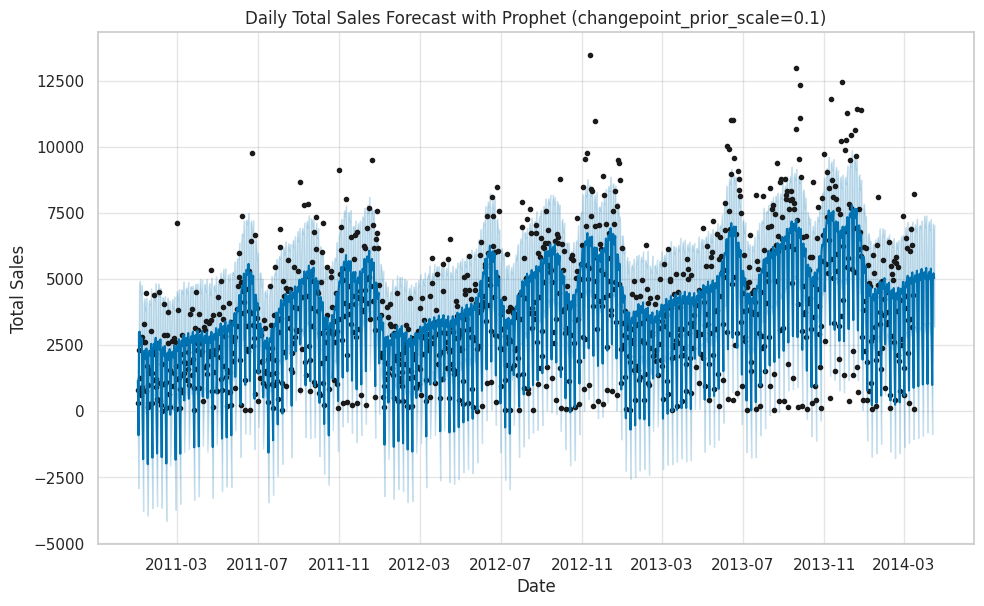

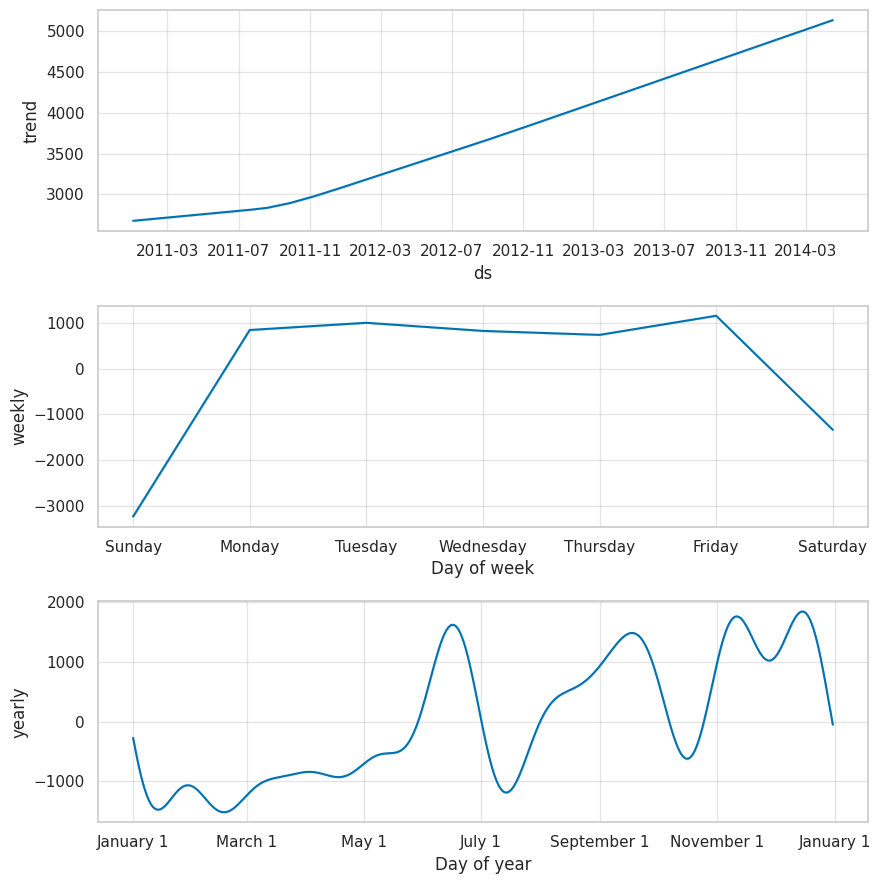

In [188]:
# Assumption: train_data and test_data already exist

param_values = [0.001, 0.01, 0.1, 0.5]
results = {}

for p in param_values:
    model_tuned = Prophet(changepoint_prior_scale=p)
    model_tuned.fit(train_data)
    future_test = pd.DataFrame(test_data['ds'])
    forecast_test = model_tuned.predict(future_test)
    predictions = forecast_test[['ds', 'yhat']].set_index('ds')
    actuals = test_data[['ds', 'y']].set_index('ds')
    mse = mean_squared_error(actuals['y'], predictions['yhat'])
    rmse = np.sqrt(mse)
    results[p] = rmse

# Print the result of basic parameter tuning
best_param = min(results, key=results.get)
print("\n[INFO] Result of Basic Tuning for changepoint_prior_scale:")
for param, rmse in results.items():
    print(f"changepoint_prior_scale = {param}: RMSE = {rmse:.2f}")
print(f"\nBest changepoint_prior_scale value (based on lowest RMSE): {best_param}")

# Train the final model using the best parameter on the full training data
best_model = Prophet(changepoint_prior_scale=best_param)
best_model.fit(train_data)
future_forecast = best_model.make_future_dataframe(periods=30)
forecast = best_model.predict(future_forecast)

# Visualize the forecast results using the tuned model
fig = best_model.plot(forecast)
plt.title(f'Daily Total Sales Forecast with Prophet (changepoint_prior_scale={best_param})')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.show()

fig2 = best_model.plot_components(forecast)
plt.show()

In [189]:
# Assumption: df_orders_ts already exists and contains columns 'Order Date' and 'Discount'

# Daily Discount Average Aggregation
daily_discount = df_orders_ts.groupby('Order Date')['Discount'].mean().reset_index()
daily_discount = daily_discount.rename(columns={'Order Date': 'ds', 'Discount': 'Discount_avg'})

print("[INFO] DataFrame daily_discount has been created:")
print(daily_discount.head())

[INFO] DataFrame daily_discount has been created:
          ds  Discount_avg
0 2011-01-01      0.133333
1 2011-01-02      0.000000
2 2011-01-03      0.186000
3 2011-01-04      0.112625
4 2011-01-05      0.171429


In [190]:
# Assumptions: df_orders_ts already exists, and train_data and test_data are already defined

# 1. Daily Discount Average Aggregation
daily_discount = df_orders_ts.groupby('Order Date')['Discount'].mean().reset_index()
daily_discount = daily_discount.rename(columns={'Order Date': 'ds', 'Discount': 'Discount_avg'})

# 2. Merge with Daily Sales Data (on train and test data)
train_data_merged = pd.merge(train_data, daily_discount, on='ds', how='left')
test_data_merged = pd.merge(test_data, daily_discount, on='ds', how='left')

# Make sure there are no NaNs after the merge (if there are, you need to handled)
train_data_merged['Discount_avg'] = train_data_merged['Discount_avg'].fillna(train_data_merged['Discount_avg'].mean())
test_data_merged['Discount_avg'] = test_data_merged['Discount_avg'].fillna(test_data_merged['Discount_avg'].mean())

# 3. Train the Prophet Model with Regressors on the train data
model_with_regressor = Prophet()
model_with_regressor.add_regressor('Discount_avg')
model_with_regressor.fit(train_data_merged)

# 4. Make Predictions on Test Data with Regressors
future_test_with_regressor = pd.DataFrame(test_data_merged[['ds', 'Discount_avg']])
forecast_test_with_regressor = model_with_regressor.predict(future_test_with_regressor)

# Model Evaluation with Regressors
predictions_with_regressor = forecast_test_with_regressor[['ds', 'yhat']].set_index('ds')
actuals_test = test_data_merged[['ds', 'y']].set_index('ds')
comparison_with_regressor = predictions_with_regressor.join(actuals_test)

mse_with_regressor = mean_squared_error(comparison_with_regressor['y'], comparison_with_regressor['yhat'])
rmse_with_regressor = np.sqrt(mse_with_regressor)
mae_with_regressor = mean_absolute_error(comparison_with_regressor['y'], comparison_with_regressor['yhat'])

print("\n[INFO] Evaluate Prophet Model with Regressor (Average Daily Discount):")
print(f"Mean Squared Error (MSE): {mse_with_regressor:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_with_regressor:.2f}")
print(f"Mean Absolute Error (MAE): {mae_with_regressor:.2f}")

20:28:28 - cmdstanpy - INFO - Chain [1] start processing
20:28:29 - cmdstanpy - INFO - Chain [1] done processing



[INFO] Evaluate Prophet Model with Regressor (Average Daily Discount):
Mean Squared Error (MSE): 5717361.22
Root Mean Squared Error (RMSE): 2391.10
Mean Absolute Error (MAE): 1823.12


---

## RFM

In [203]:
# --- Bagian 1: Perhitungan RFM Metrics (Recency, Frequency, Monetary) ---
# Assumption: df_orders_ca already exists and contains transaction data with 'Customer ID', 'Order Date', and 'Sales' columns

# Convert 'Order Date' to datetime if not already
df_orders_ca['Order Date'] = pd.to_datetime(df_orders_ca['Order Date'])

# Define the analysis date
analysis_date = df_orders_ca['Order Date'].max() + pd.Timedelta(days=1)

# Calculate Recency
recency_df = df_orders_ca.groupby('Customer ID')['Order Date'].max().reset_index()
recency_df['Recency'] = (analysis_date - recency_df['Order Date']).dt.days
recency_df = recency_df[['Customer ID', 'Recency']]

# Calculate Frequency
frequency_df = df_orders_ca.groupby('Customer ID')['Order ID'].nunique().reset_index()
frequency_df.columns = ['Customer ID', 'Frequency']

# Calculate Monetary Value
monetary_df = df_orders_ca.groupby('Customer ID')['Sales'].sum().reset_index()
monetary_df.columns = ['Customer ID', 'Monetary']

# Merge all RFM metrics into a single DataFrame
rfm_df = recency_df.merge(frequency_df, on='Customer ID')
rfm_df = rfm_df.merge(monetary_df, on='Customer ID')

print("[INFO] RFM DataFrame (Initial):")
print(rfm_df.head())

[INFO] RFM DataFrame (Initial):
  Customer ID  Recency  Frequency     Monetary
0    AA-10315        9         19  13747.41300
1    AA-10375        7         23   5884.19500
2    AA-10480      126         20  17695.58978
3    AA-10645       29         36  15343.89070
4      AA-315        3          7   2243.25600


In [204]:
# --- DEBUGGING STEP 1: Check the RFM DataFrame content ---
print("\n--- DEBUGGING: RFM DataFrame Content Check ---")
print("Is rfm_df empty?", rfm_df.empty)
print("Number of rows in rfm_df:", len(rfm_df))
print("\nMissing values in RFM columns:")
print(rfm_df[['Recency', 'Frequency', 'Monetary']].isnull().sum())
print("\nDescriptive statistics for RFM columns:")
print(rfm_df[['Recency', 'Frequency', 'Monetary']].describe())
print("---------------------------------------------")


--- DEBUGGING: RFM DataFrame Content Check ---
Is rfm_df empty? False
Number of rows in rfm_df: 1590

Missing values in RFM columns:
Recency      0
Frequency    0
Monetary     0
dtype: int64

Descriptive statistics for RFM columns:
           Recency    Frequency      Monetary
count  1590.000000  1590.000000   1590.000000
mean     85.432704    16.196855   7951.729503
std     127.746455    10.619199   6937.118160
min       1.000000     1.000000      7.173000
25%      15.000000     6.000000   1674.812250
50%      36.000000    14.000000   6248.135590
75%     100.000000    26.000000  13133.098420
max    1207.000000    41.000000  35668.120800
---------------------------------------------


In [205]:
# --- Bagian 2: RFM Scoring (menggunakan pd.qcut untuk robustness) ---
# Tentukan jumlah segmen (misalnya, 5 untuk skor 1 hingga 5)
segment_count = 5

# Gunakan pd.qcut untuk membagi data ke dalam kuantil dan memberikan label skor
# Untuk Recency: Skor 5 adalah yang paling baru (nilai kecil), jadi labelnya dibalik
rfm_df['R_Score'] = pd.qcut(
    rfm_df['Recency'],
    q=segment_count,
    labels=range(segment_count, 0, -1), # labels=[5, 4, 3, 2, 1]
    duplicates='drop' # Tangani jika ada nilai duplikat di kuantil batas
).astype(int)

# Untuk Frequency dan Monetary: Skor 5 adalah yang paling tinggi (nilai besar), jadi labelnya normal
rfm_df['F_Score'] = pd.qcut(
    rfm_df['Frequency'],
    q=segment_count,
    labels=range(1, segment_count + 1), # labels=[1, 2, 3, 4, 5]
    duplicates='drop'
).astype(int)

rfm_df['M_Score'] = pd.qcut(
    rfm_df['Monetary'],
    q=segment_count,
    labels=range(1, segment_count + 1), # labels=[1, 2, 3, 4, 5]
    duplicates='drop'
).astype(int)

# Gabungkan skor RFM menjadi satu segmen string
rfm_df['RFM_Segment'] = rfm_df['R_Score'].astype(str) + \
                        rfm_df['F_Score'].astype(str) + \
                        rfm_df['M_Score'].astype(str)

# Hitung skor RFM gabungan (jumlah skor)
rfm_df['RFM_Score'] = rfm_df[['R_Score', 'F_Score', 'M_Score']].sum(axis=1)

print("\n[INFO] RFM DataFrame after Scoring (menggunakan pd.qcut):")
print(rfm_df.head())


[INFO] RFM DataFrame after Scoring (menggunakan pd.qcut):
  Customer ID  Recency  Frequency     Monetary  R_Score  F_Score  M_Score  \
0    AA-10315        9         19  13747.41300        5        3        4   
1    AA-10375        7         23   5884.19500        5        4        3   
2    AA-10480      126         20  17695.58978        1        3        5   
3    AA-10645       29         36  15343.89070        3        5        5   
4      AA-315        3          7   2243.25600        5        2        2   

  RFM_Segment  RFM_Score  
0         534         12  
1         543         12  
2         135          9  
3         355         13  
4         522          9  



[INFO] Determining Optimal K for K-Means using Elbow Method...


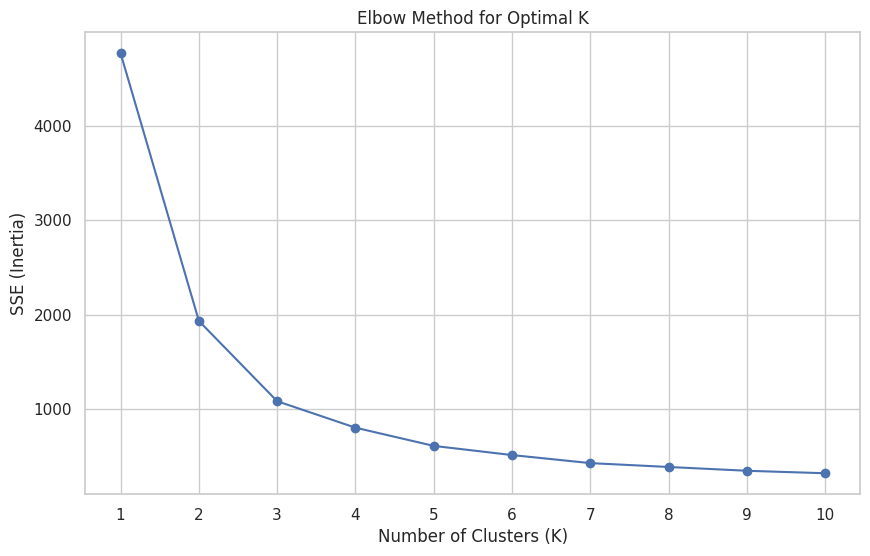


[INFO] Review the Elbow plot above to select the optimal 'n_clusters'.

[INFO] Optimal number of clusters selected: 3

[INFO] RFM DataFrame with K-Means Clusters:
  Customer ID  Recency  Frequency     Monetary  R_Score  F_Score  M_Score  \
0    AA-10315        9         19  13747.41300        5        3        4   
1    AA-10375        7         23   5884.19500        5        4        3   
2    AA-10480      126         20  17695.58978        1        3        5   
3    AA-10645       29         36  15343.89070        3        5        5   
4      AA-315        3          7   2243.25600        5        2        2   

  RFM_Segment  RFM_Score  Cluster  
0         534         12        1  
1         543         12        1  
2         135          9        1  
3         355         13        1  
4         522          9        2  


In [206]:
# --- Bagian 3: K-Means Clustering for Customer Segmentation ---
# Pilih fitur RFM untuk clustering
rfm_features = ['Recency', 'Frequency', 'Monetary']
X = rfm_df[rfm_features]

# Standardisasi fitur agar memiliki mean 0 dan varians 1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Menentukan Optimal K untuk K-Means menggunakan Elbow Method ---
print("\n[INFO] Determining Optimal K for K-Means using Elbow Method...")
sse = {} # Sum of Squared Errors
for k in range(1, 11): # Coba k dari 1 hingga 10
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    sse[k] = kmeans.inertia_ # Inertia adalah SSE

# Plot the Elbow Method results
plt.figure(figsize=(10, 6))
plt.plot(list(sse.keys()), list(sse.values()), marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('SSE (Inertia)')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

print("\n[INFO] Review the Elbow plot above to select the optimal 'n_clusters'.")

# --- LANGKAH PENTING: Pilih K yang Optimal di SINI ---
# Contoh: Jika Anda melihat Elbow ada di k=3, maka:
n_clusters_optimal = 3 # <--- GANTI ANGKA INI DENGAN K YANG ANDA PILIH DARI PLOT ELBOW ANDA

print(f"\n[INFO] Optimal number of clusters selected: {n_clusters_optimal}")

# Latih model K-Means dengan K yang optimal
kmeans = KMeans(n_clusters=n_clusters_optimal, random_state=42, n_init=10)
rfm_df['Cluster'] = kmeans.fit_predict(X_scaled)

print("\n[INFO] RFM DataFrame with K-Means Clusters:")
print(rfm_df.head())

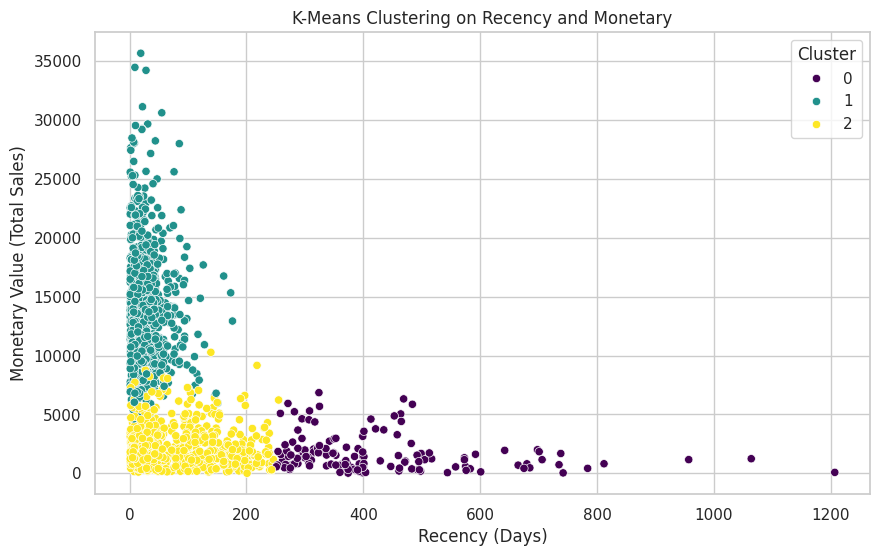

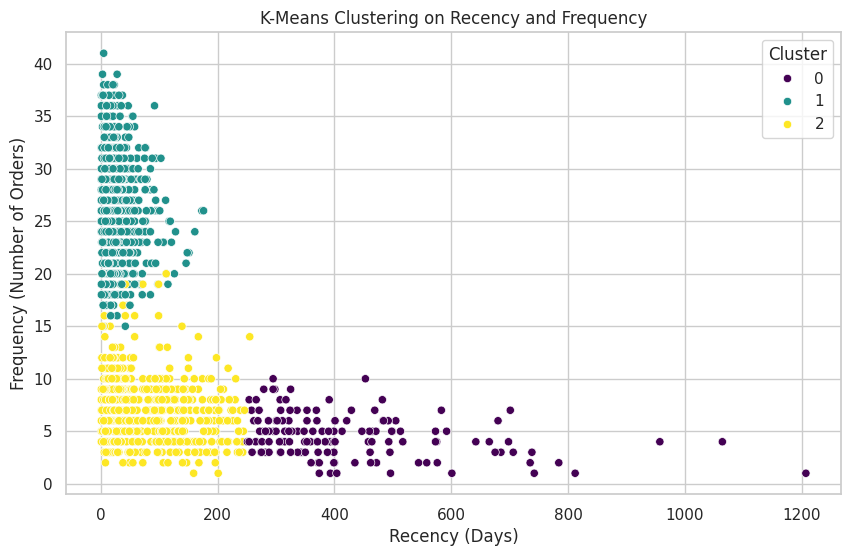

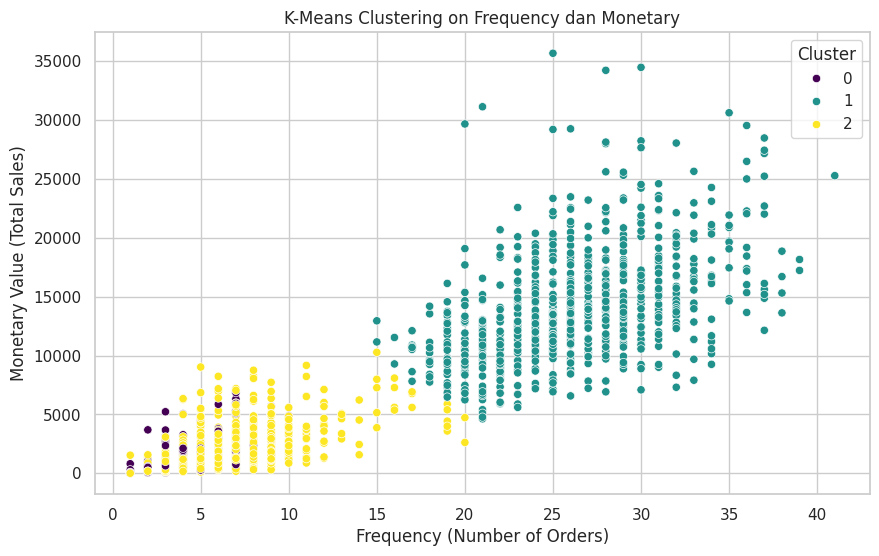


[INFO] Cluster Sizes:
Cluster
0    143
1    773
2    674
Name: count, dtype: int64

[INFO] Mean RFM values per Cluster (for interpretation):
            Recency  Frequency      Monetary
Cluster                                     
0        421.349650   4.538462   1663.781926
1         28.345408  26.331177  14047.178125
2         79.635015   7.047478   2295.045110


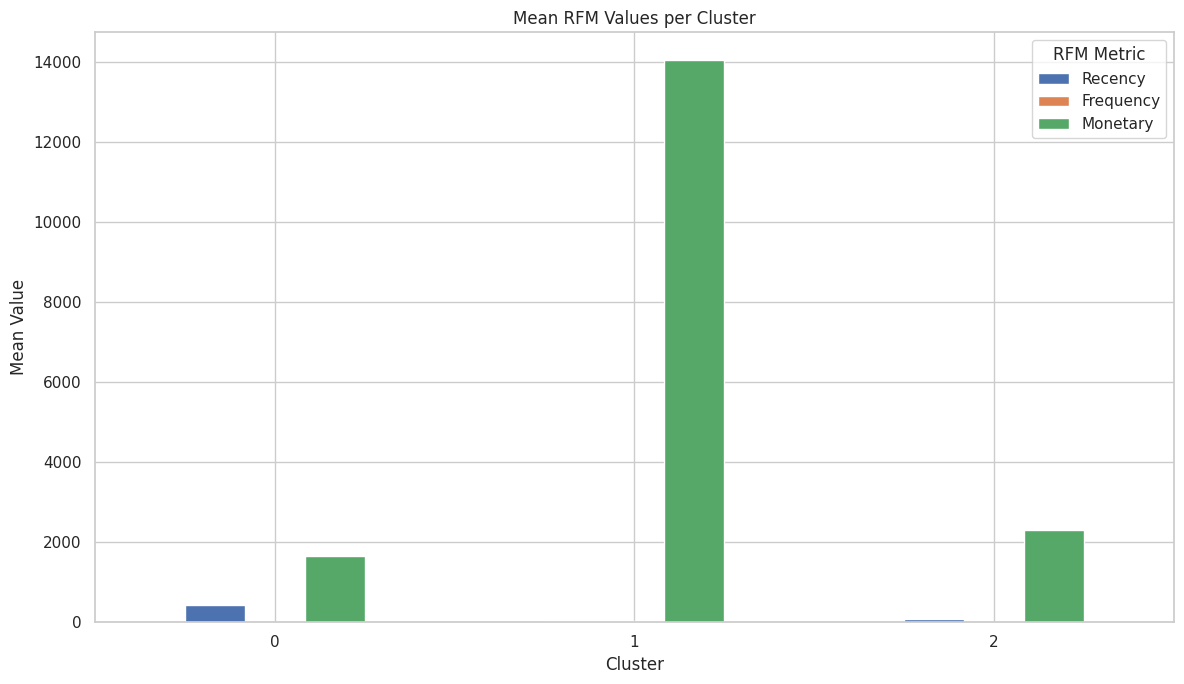


[INFO] Mean RFM Scores per Cluster:
          R_Score   F_Score   M_Score  RFM_Score
Cluster                                         
0        1.000000  1.202797  1.608392   3.811189
1        3.737387  4.160414  4.232859  12.130660
2        2.609792  1.787834  1.881306   6.278932


In [207]:
# --- Bagian 4: Visualisasi dan Analisis Cluster ---
# Visualisasi cluster (hanya untuk 2 fitur pada satu waktu)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm_df, x='Recency', y='Monetary', hue='Cluster', palette='viridis')
plt.title('K-Means Clustering on Recency and Monetary')
plt.xlabel('Recency (Days)')
plt.ylabel('Monetary Value (Total Sales)')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm_df, x='Recency', y='Frequency', hue='Cluster', palette='viridis')
plt.title('K-Means Clustering on Recency and Frequency')
plt.xlabel('Recency (Days)')
plt.ylabel('Frequency (Number of Orders)')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm_df, x='Frequency', y='Monetary', hue='Cluster', palette='viridis')
plt.title('K-Means Clustering on Frequency dan Monetary')
plt.xlabel('Frequency (Number of Orders)')
plt.ylabel('Monetary Value (Total Sales)')
plt.show()

# Analisis ukuran cluster
print("\n[INFO] Cluster Sizes:")
print(rfm_df['Cluster'].value_counts().sort_index())

# Analisis mean RFM values per cluster
print("\n[INFO] Mean RFM values per Cluster (for interpretation):")
cluster_profiles = rfm_df.groupby('Cluster')[rfm_features].mean()
print(cluster_profiles)

# Visualisasi Bar Plot untuk Profil Cluster (lebih mudah diinterpretasi)
cluster_profiles.plot(kind='bar', figsize=(12, 7))
plt.title('Mean RFM Values per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Mean Value')
plt.xticks(rotation=0)
plt.legend(title='RFM Metric')
plt.tight_layout()
plt.show()

# Jika Anda juga ingin melihat distribusi skor (bukan hanya nilai mentah)
print("\n[INFO] Mean RFM Scores per Cluster:")
cluster_score_profiles = rfm_df.groupby('Cluster')[['R_Score', 'F_Score', 'M_Score', 'RFM_Score']].mean()
print(cluster_score_profiles)
